<a href="https://colab.research.google.com/github/DanielMolinaR/Cassava-Leaf-Disease-Classification/blob/main/Cassava_CNN_classificaiton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 07MIAR - Redes Neuronales y Deep Learning: Proyecto de programación "*Deep Vision in classification tasks*"


## Enunciado

En esta actividad, el alumno debe **evaluar y comparar dos estrategias** para la **clasificación de imágenes** empleando el **dataset asignado**. El/La alumnx deberá resolver el reto proponiendo una solución válida **basada en aprendizaje profundo**, más concretamente en redes neuronales convolucionales (**CNNs**). Será indispensable que la solución propuesta siga el **pipeline visto en clase** para resolver este tipo de tareas de inteligencia artificial:

1.   **Carga** del conjunto de datos
2.   **Inspección** del conjunto de datos
3.   **Acondicionamiento** del conjunto de datos
4.   Desarrollo de la **arquitectura** de red neuronal y **entrenamiento** de la solución
5.   **Monitorización** del proceso de **entrenamiento** para la toma de decisiones
6.   **Evaluación** del modelo predictivo y planteamiento de la siguiente prueba experimental

### Estrategia 1: Entrenar desde cero o *from scratch*

La primera estrategia a comparar será una **red neuronal profunda** que el **alumno debe diseñar, entrenar y optimizar**. Se debe **justificar empíricamente** las decisiones que llevaron a la selección de la **arquitectura e hiperparámetros final**. Se espera que el alumno utilice todas las **técnicas de regularización** mostradas en clase de forma justificada para la mejora del rendimiento de la red neuronal (*weight regularization*, *dropout*, *batch normalization*, *data augmentation*, etc.).

### Estrategia 2: Red pre-entrenada

La segunda estrategia a comparar debe incluir la utilización de una **red preentrenada** con el dataset ImageNet, llevando a cabo tareas de ***transfer learning*** y ***fine-tuning*** para resolver la tarea de clasificación asignada. Deben **compararse al menos dos tipos de arquitecturas** (VGGs, ResNet50, Xception, InceptionV3, InceptionResNetV2, MobileNetV2, DenseNet, ResNet) y se debe **seleccionar la que mayor precisión proporcione** (información sobre las arquitecturas disponibles en https://keras.io/applications/). Se espera que el/la alumnx utilice todas las **técnicas de regularización** mostradas en clase de forma justificada para la mejora del rendimiento de la red neuronal (*weight regularization*, *dropout*, *batch normalization*, *data augmentation*, etc.).

## Normas a seguir

- Será **indispensable** realizar el **trabajo por parejas**. Dichas parejas de alumnxs se generarán **de manera automática** teniendo en cuenta el pais de residencia con el objetivo de facilitar el trabajo en equipo.  
- Se debe entregar un **ÚNICO FICHERO PDF POR ALUMNO** que incluya las instrucciones presentes en el Colab Noteboook y su **EJECUCIÓN!!!**. Debe aparecer todo el proceso llevado a cabo en cada estrategia (i.e. carga de datos, inspección de datos, acondicionamiento, proceso de entrenamiento y proceso de validación del modelo).
- **La memoria del trabajo** (el fichero PDF mencionado en el punto anterior) deberá **subirla cada integrante del grupo** (aunque se trate de un documento idéntico) a la actividad que se habilitará **en CampusVIU**.
- Se recomienda trabajar respecto a un directorio base (**BASE_FOLDER**) para facilitar el trabajo en equipo. En este notebook se incluye un ejemplo de cómo almacenar/cargar datos utilizando un directorio base.
- Las **redes propuestas** deben estar **entrenadas** (y **EVIDENCIAR este proceso en el documento PDF**). La entrega de una **red sin entrenar** supondrá **perdida de puntos**.
- Si se desea **evidenciar alguna métrica** del proceso de entrenamiento (precisión, pérdida, etc.), estas deben ser generadas.
- Todos los **gráficos** que se deseen mostrar deberán **generarse en el Colab Notebook** para que tras la conversión aparezcan en el documento PDF.

## *Tips* para realizar la actividad con éxito
- Los **datos** se cargarán directamente **desde** la plataforma **Kaggle** mediante su API (https://github.com/Kaggle/kaggle-api). En este Notebook se incluye un ejemplo de como hacerlo. Se recomienda generar una función que aborde esta tarea.
- El **documento PDF a entregar** como solución de la actividad se debe **generar automáticamente desde el fichero ".ipynb"**. En este Notebook se incluye un ejemplo de como hacerlo.
- **Generar secciones y subsecciones en el Colab Notebook** supondrá que el documento **PDF generado** queda totalmente **ordenado** facilitando la evaluación al docente.
- Se recomienda encarecidamente **incluir comentarios concisos pero aclaratorios**. 
- Es muy recomendable crear una **última sección** de texto en el Colab Notebook en la que se discutan los diferentes modelos obtenidos y se extraigan las conclusiones pertinentes.

## Criterios de evaluación

- **Seguimiento** de las **normas establecidas** en la actividad (detalladas anteriormente).
- Creación de una **solución que resuelva la tarea de clasificación**, i.e. que las figuras de mérito empleadas para medir la bondad del modelo predictivo evidencien un *performance* superior al rendimiento estocástico.
- **Claridad** en la creación de la solución, en las justificaciones sobre la toma de decisiones llevada a cabo así como en las comparativas y conclusiones finales.
- **Efectividad** al presentar las comparaciones entre métricas de evaluación de ambas estrategias.
- **Demostración** de la utilización de **técnicas de regularización** para mejorar el rendimiento de los modelos.

# Desarrollo del trabajo

Primeramente, se descarga el dataset asignado de la plataforma Kaggle y se sube al Drive, puesto que el método upload de google.colab files daba error. 

## **Carga e inspección** del conjunto de datos

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os
relative_notebook_path = '/content/drive/MyDrive/Master AI/Redes neuronales/Practica'
current_notebook_dir = '/dataset'
base_folder = relative_notebook_path + current_notebook_dir
files = os.listdir(base_folder)
print(files)

['train.csv', 'label_num_to_disease_map.json', 'sample_submission.csv', 'train_images', 'train_tfrecords', 'test_tfrecords', 'test_images']


Se observa que en el dataset se incluyen dos archivos csv, un archivo json y cuatro carpetas. 

In [6]:
csv_files = [file for file in files if file.endswith('.csv')]
print(f'Los archivos csv son:\n{csv_files}\n')

json_files = [file for file in files if file.endswith('.json')]
print(f'Los archivos json son:\n{json_files}\n')

folders = []
for element in files:
  if element not in csv_files and element not in json_files:
    folders.append(element)
print(f'Las carpetas son:\n{folders}\n')

print(f'Todos los archivos y carpetas, como ya se vio, son:\n{files}')

Los archivos csv son:
['train.csv', 'sample_submission.csv']

Los archivos json son:
['label_num_to_disease_map.json']

Las carpetas son:
['train_images', 'train_tfrecords', 'test_tfrecords', 'test_images']

Todos los archivos y carpetas, como ya se vio, son:
['train.csv', 'label_num_to_disease_map.json', 'sample_submission.csv', 'train_images', 'train_tfrecords', 'test_tfrecords', 'test_images']


In [7]:
import pandas as pd

for csv in csv_files:
  df_csv = pd.read_csv(base_folder + '/' + csv)
  print(f'En el archivo {csv} se obtiene este sampleo:\n{df_csv.sample(1)}\n')

En el archivo train.csv se obtiene este sampleo:
             image_id  label
16786  4019771530.jpg      3

En el archivo sample_submission.csv se obtiene este sampleo:
         image_id  label
0  2216849948.jpg      4



Con esto, se comprueba la información que indican los nombres de los archivos. El archivo train.csv asocia para cada imagen de train su etiqueta correspondiente mientras que el archivo sample_submission.csv hace lo propio con las imágenes de ejemplo o de test. Se va a comprobar a continuación cuántas etiquetas hay, así como imágenes de train y test, cuantas imágenes hay para cada etiqueta.

In [14]:
import numpy as np

df_training_labels = pd.read_csv(base_folder + '/' + csv_files[0])
df_test_labels = pd.read_csv(base_folder + '/' + csv_files[1])

labels_number = df_training_labels['label'].unique().tolist()
labels = labels_number.sort()
print(f'Existen {len(labels_number)} etiquetas para la clasificación de las imágenes, que son:\n')

print(labels_number)

print('\nY cada una de las etiquetas tiene la siguiente cantidad de imágenes: ')
print(df_training_labels['label'].value_counts())

training_samples = len(df_training_labels)
test_samples = len(df_test_labels)
print(f'\nAdemás, existen {training_samples} muestras de training y {test_samples} muestras del conjunto de test.')

Existen 5 etiquetas para la clasificación de las imágenes, que son:

[0, 1, 2, 3, 4]

Y cada una de las etiquetas tiene la siguiente cantidad de imágenes: 
3    13158
4     2577
2     2386
1     2189
0     1087
Name: label, dtype: int64

Además, existen 21397 muestras de training y 1 muestras del conjunto de test.


El reparto entre muestras de training y test se encuentra claramente desbalanceado, por lo que deberá corregirse para acercarse a una proporción adecuada de muestras y poder valorar adecuadamente la validez del modelo. Estas proporciones serán de 80-20, siendo mayoría las muestras de training.

In [15]:
import json
with open(base_folder + '/' + json_files[0], 'r') as j_file:
  labels_dict = json.load(j_file)

print(labels_dict)

{'0': 'Cassava Bacterial Blight (CBB)', '1': 'Cassava Brown Streak Disease (CBSD)', '2': 'Cassava Green Mottle (CGM)', '3': 'Cassava Mosaic Disease (CMD)', '4': 'Healthy'}


El archivo json recoge un diccionario con cada etiqueta que se le ha asignado a las imágenes como clave y el nombre del tipo de enfermedad que tiene la planta 'Cassava' como valor.

In [29]:
train_images_folder = base_folder + '/' + folders[0]
with os.scandir(train_images_folder) as f1:
  train_images = [image.name for image in f1]

print(f'En la carpeta train_images se comprueba que efectivamente se encuentran las {len(train_images)} imágenes de training.\n')

test_images_folder = base_folder + '/' + folders[-1]
with os.scandir(test_images_folder) as f4:
  test_images = [image.name for image in f4]

print(f'En la carpeta test_images se comprueba que efectivamente se encuentra la {len(test_images)} imagen de test.\n')

En la carpeta train_images se comprueba que efectivamente se encuentran las 21397 imágenes de training.

En la carpeta test_images se comprueba que efectivamente se encuentra la 1 imagen de test.



Por último, se ha comprobado que en las carpetas train_images y test_images se encuentran las imágenes de training y test respectivamente. Las carpetas de train_tfrecords y test_tfrecords no se analizan puesto que no se van a utilizar en el trabajo, al tratarse de esas imágenes en formato TFRecord. A continuación se muestra una imagen de training y otra de test:

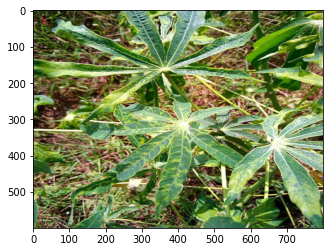

In [17]:
import cv2
import matplotlib.pyplot as plt

idx_train = np.random.randint(0, 21396)
idx_test = 0
img_train = cv2.imread(train_images_folder + '/' + train_images[idx_train], cv2.COLOR_BGR2RGB)
img_test = cv2.imread(test_images_folder + '/' + test_images[idx_test], cv2.COLOR_BGR2RGB)


img_train = cv2.cvtColor(img_train, cv2.COLOR_BGR2RGB)
img_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB)

plt.imshow(img_train)

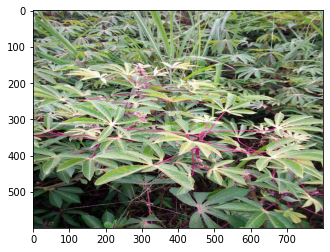

In [18]:
plt.imshow(img_test)

## **Acondicionamiento** del conjunto de datos

En este apartado vamos a dividir nuestro dataset de entrenamiento en entrenamiento-test en una proporción del 75/25 debido a que nuestra carpeta de test tan solo tiene una imagen. Tras analizar los datos en el apartado anterior hemos comprobado que la mayoría de la imágenes son de la clase 3 que corresponde a Cassava Mosaic Disease (CMD). Aún así hemos decididdo realizar una separación proporcional para todas las clases ddel tipo 75/25 de forma aleatoria.



In [25]:
df_total_test = pd.DataFrame()
df_total_train = pd.DataFrame()

# Recorremos la lista de etiquetas
for i in labels_number:

  #Cogemos un dataframe auxiliar de solo la etiqueta en la que estamos
  df_aux = df_training_labels[df_training_labels['label'] == i]

  # Cogemos el 25% del dataframe auxiliar para test y lo alamacenamos
  df_test = df_aux.sample(frac=0.25)
  df_total_test = pd.concat([df_total_test,df_test])

  # Cogemos el 75% restante para train y lo alamacenamos
  df_train = df_aux.drop(df_test.index)
  df_total_train = pd.concat([df_total_train,df_train])

print(df_total_test.shape)
print(df_total_train.shape)

(5349, 2)
(16048, 2)


Ahora vamos a proceder a la carga de las imágenes y la dimesionalización de estas. Para ello cargamos las siguientes librerías:

In [26]:
from cv2 import imread
from tensorflow.keras.backend import expand_dims

Para la carga y dimensionalización de las imágenes vamos a recorrer los dataframes de test y train los cuales contienen los nombres de las imágenes y sus clases. Por cada imagen que recorramos la **cargaremos** en memoria desde la carpeta, **expandiremos su dimensión** y la **almacenaremos**, seguidamente al macenaremos su clase en otra variable pero manteniendo el mismo orden. Primero haremos este paso con test y luego con train. Finalmente obtendremos **testX** con la imágenes dimensionalizadas y **testY** con las etiquetas de las clases dimensionalizadas y lo mismo para train.

In [31]:
def expanse_and_separate(df):
  # Definimos dataX y dataY los cuales pueden ser testX y testY o trainX y trainY
  dataX = np.empty(shape=(1,600,800,3))
  dataY = np.empty(shape=(1))
  contador = 0
  for i in range(len(df)):
    # Cargamos la imagen en una variable
    img = imread(train_images_folder + '/' + df.iloc[i,0], -1)
    # Expandimos su dimensionalidad y la almacenamos
    img = expand_dims(img, axis=0)
    dataX = np.concatenate((dataX,img), axis = 0)

  # Extraemos su correspondiente etiqueta y la almacenamos en la misma posición
    label = expand_dims(df.iloc[i,1], axis=0)
    dataY = np.concatenate((dataY,label), axis = 0)

    contador += 1 
    print(f'LLevamos {contador} iteraciones de {len(df)}')

  return dataX, dataY

In [ ]:
testX, testY = expanse_and_separate(df_total_test)
print(testY.shape)
print(testX.shape)

In [ ]:
trainX, trainY = expanse_and_separate(df_total_train)
print(trainY.shape)
print(trainX.shape)

In [ ]:
testX = np.empty(shape=(1,600,800,3))
testY = np.empty(shape=(1))

contador = 0
for i in range(len(df_total_test)):
  # Cargamos la imagen en una variable
  img = imread(train_images_folder + '/' + df_total_test.iloc[i,0], -1)
  # Expandimos su dimensionalidad y la almacenamos
  img = expand_dims(img, axis=0)
  testX = np.concatenate((testX,img), axis = 0)

  # Extraemos su correspondiente etiqueta y la almacenamos en la misma posición
  label = expand_dims(df_total_test.iloc[i,1], axis=0)
  testY = np.concatenate((testY,label), axis = 0)

  contador += 1 
  print(f'LLevamos {contador} iteraciones de {len(df_total_test)}')

print(testY.shape)
print(testX.shape)

# Repetimos los mismos pasos para train
trainX = np.empty(shape=(1,600,800,3))
trainY = np.empty(shape=(1))
contador = 0
for i in range(len(df_total_train)):
  img = imread(train_images_folder + '/' + df_total_train.iloc[i,0], -1)
  img = expand_dims(img, axis=0)
  trainX = np.concatenate((trainX,img), axis = 0)

  label = expand_dims(df_total_train.iloc[i,1], axis=0)
  trainY = np.concatenate((trainY,label), axis = 0)

  contador += 1 
  print(f'LLevamos {contador} iteraciones de {len(df_total_train)}')

#trainX = trainX.astype("float") / 255.0
print(trainY.shape)
print(trainX.shape)

## trainX tiene que ser un array multidim con (muestras, pix, pix, 3), trainY un array multidim con (muestras, 1)
## testX y testY igual pero con las muestras de test

In [ ]:
## trainX = (16048, 600, 800, 3)
## trainY = (16048,)

## testX = (5349, 600, 800, 3)
## testY = (5349,)

# Cosas que da el profesor

## Ejemplo de carga de datos desde la plataforma Kaggle

In [ ]:
# En primer lugar se debe generar un API de Kaggle personal, para ello:
#  1. Registrarse en  https://www.kaggle.com
#  2. Ir a 'Account tab' de tu perfil y seleccionar 'Create API Token'
#  3. Almacenar en tu ordenador local el fichero kaggle.json

In [ ]:
# Nos aseguramos que tenemos instalada la última versión de la API de Kaggle en Colab
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 58 kB 3.0 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=1f65ddf44260ccf26d454dadbb1b954d1e0f1412a47991855414be646d3e6f8a
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [ ]:
# Seleccionar el API Token personal previamente descargado (fichero kaggle.json)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture
# Seleccionar el API Token personal previamente descargado (fichero kaggle.json)
from google.colab import files
uploaded = files.upload()

MessageError: ignored

In [ ]:
# Creamos un directorio en el que copiamos el fichero kaggle.json
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/content/drive/MyDrive/Practica/.kaggle/kaggle.json': No such file or directory


In [ ]:
# Ya podemos listar los datasets disponibles en kaggle para su descarga
!kaggle datasets list

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 166, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
# IMPORTANTE ANTES DE DESCARGAR UN DATASET !!!
# Antes de descargar el dataset debemos ir a https://www.kaggle.com/c/$nameCompetition/data y aceptar las "Competition Rules"
# En caso de no realizar el paso anterior al descargar el dataset obtenedremos el siguiente mensaje "403 - Forbidden"
# AHORA SI: Descarguemos un dataset de cierta competición
!kaggle competitions download -c cassava-leaf-disease-classification

#NOTA: El nombre del dataset de competición a descargar se informará en el documento en el que se presenten las parejas formadas

100% 810M/814M [00:21<00:00, 48.9MB/s]
100% 814M/814M [00:21<00:00, 39.3MB/s]


In [ ]:
# Creemos un directorio para descomprimir los datos
!mkdir my_dataset

In [ ]:
# Descomprimimos los datos y los dejamos listos para trabajar
!unzip dogs-vs-cats-redux-kernels-edition.zip -d my_dataset

Archive:  dogs-vs-cats-redux-kernels-edition.zip
  inflating: my_dataset/sample_submission.csv  
  inflating: my_dataset/test.zip     
  inflating: my_dataset/train.zip    


In [ ]:
!unzip my_dataset/test.zip

In [ ]:
%%capture
!ls test/

## Ejemplo de escritura de datos tomando como referencia un BASE_FOLDER

In [ ]:
# Conectamos con nuestro Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Establezco una ruta absoluta a un directorio existente de mi Google Drive
BASE_FOLDER = "/content/drive/MyDrive/07MIAR_Proyecto_Programacion/"

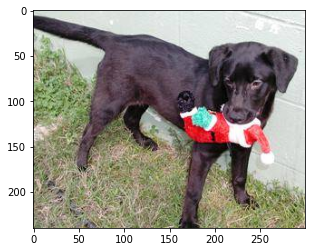

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Escogiendo y mostrando una imagen al azar del conjunto de test
idx = np.random.randint(1, 12000)
img = cv2.imread('test/' + str(idx) + '.jpg', cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [ ]:
# Almacenando una imagen aleatoria de test en mi BASE_FOLDER
cv2.imwrite(BASE_FOLDER + 'my_pet.png', img)

True

## Ejemplo de generación de documento PDF a partir del Colab Notebook (fichero ".ipynb")

In [ ]:
# Ejecutando los siguientes comandos en la última celda del Colab Notebook se convierte de ".ipynb" a PDF
# En caso de querer ocultar la salida de una celda puesto que no tenga relevancia se debe insertar 
# el comando %%capture al inicio de la misma. Véase la celda que contiene !ls test en este Notebook.

In [ ]:
name_IPYNB_file = '07MIAR_Proyecto_Programacion.ipynb'
get_ipython().system(
        "apt update >> /dev/null && apt install texlive-xetex texlive-fonts-recommended texlive-generic-recommended >> /dev/null"
    )
get_ipython().system(
            "jupyter nbconvert --output-dir='$BASE_FOLDER' '$BASE_FOLDER''$name_IPYNB_file' --to pdf"
        )





[NbConvertApp] Converting notebook /content/drive/MyDrive/07MIAR_Proyecto_Programacion/07MIAR_Proyecto_Programacion.ipynb to pdf
[NbConvertApp] Support files will be in 07MIAR_Proyecto_Programacion_files/
[NbConvertApp] Making directory ./07MIAR_Proyecto_Programacion_files
[NbConvertApp] Writing 43232 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: [u'xelatex', u'./notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: [u'bibtex', u'./notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 179055 bytes to /content/drive/MyDrive/07MIAR_Proyecto_Programacion/07MIAR_Proyecto_Programacion.pdf
